# Constant-Silica Reference Model

This Jupyter notebook runs the <a href="https://github.com/brenhinkeller/StatGeochem.jl" target="_blank">StatGeochem</a> package, which includes (among other things) a version of the weighted bootstrap resampling code described in <a href="https://doi.org/10.1038/nature11024" target="_blank">Keller & Schoene 2012</a> and <a href="https://doi.org/10.1016/j.epsl.2017.10.031" target="_blank">2018</a> implemented in the <a href="https://julialang.org" target="_blank">Julia language</a>. 

In this notebook, we use these tools to consider a hypothetical reference model in which the proprtion of mafic, felsic, and intermediate rocks has remained constant through time

<a href="https://mybinder.org/v2/gh/brenhinkeller/StatGeochem.jl/master?filepath=examples%2FConstantSilicaReferenceModel.ipynb" target="_blank"><img src="https://mybinder.org/badge_logo.svg" alt="Launch Binder notebook" align="left"></a> 
<p style="text-indent: 5px">If running this notebook as an online Binder notebook and the webpage times out, click the badge at left to relaunch (refreshing will not work). Note that any changes will be lost!</p>

Hint: `shift`-`enter` to run a single cell, or from the `Cell` menu select `Run All` to run the whole file. Any code from this notebook can be copied and pasted into the Julia REPL or a `.jl` script.
***
### Load required Julia packages

In [1]:
## --- Load (and install if neccesary) the StatGeochem package which has the resampling functions we'll want
try
    using StatGeochem
catch
    using Pkg
    Pkg.add(PackageSpec(url="https://github.com/brenhinkeller/StatGeochem.jl"))
    using StatGeochem
end

using Statistics, StatsBase, DelimitedFiles
using Plots; gr();

### Load dataset

In [2]:
## --- Download and unzip Keller and Schoene (2012) dataset

if ~isfile("ign.h5") # Unless it already exists
    download("https://storage.googleapis.com/statgeochem/ign.h5.gz","./ign.h5.gz")
    download("https://storage.googleapis.com/statgeochem/err2srel.csv","./err2srel.csv")
    run(`gunzip -f ign.h5.gz`) # Unzip file
end

# Read HDF5 file
using HDF5
ign = h5read("ign.h5","vars")

Dict{String,Any} with 117 entries:
  "Lower_Vp"   => [7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2  …  7.2, 7.…
  "Pd"         => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  0.01, N…
  "MgO"        => [0.89, 0.5, 0.69, 2.83, 3.5, 2.81, 2.97, 2.32, 2.33, 1.74  … …
  "C"          => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, Na…
  "Nb"         => [3.5, 1.3, 3.4, 11.6, 10.4, 12.2, 11.5, 8.3, 7.0, 4.9  …  11.…
  "Ag"         => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  0.66, N…
  "Gd"         => [NaN, NaN, NaN, 7.99, 5.92, 6.12, 5.94, 5.46, 2.01, 2.7  …  N…
  "Middle_Rho" => [2.9, 2.9, 2.9, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8  …  2.9, 2.…
  "Age"        => [1.0, 1.0, 1.0, 1650.0, 1650.0, 1650.0, 1650.0, 1650.0, 1650.…
  "Sb"         => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, 1.…
  "TiO2"       => [0.27, 0.25, 0.24, 0.6, 0.63, 0.63, 0.59, 0.39, 0.48, 0.38  ……
  "Cs"         => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  Na

In [3]:
## --- Compute proximity coefficients (inverse weights)

# # Compute inverse weights
# k = invweight(ign["Latitude"] .|> Float32, ign["Longitude"] .|> Float32, ign["Age"] .|> Float32)

# Since this is somewhat computatually intensive, let's load a precomputed version instead
k = ign["k"]

# Probability of keeping a given data point when sampling
p = 1.0 ./ ((k .* median(5.0 ./ k)) .+ 1.0) # Keep rougly one-fith of the data in each resampling
p[vec(ign["Elevation"].<-100)] .= 0 # Consider only continental crust

# Calculate age uncertainty
ign["Age_sigma"] = (ign["Age_Max"]-ign["Age_Min"])/2;
t = (ign["Age_sigma"] .< 50) .| isnan.(ign["Age_sigma"]) # Find points with < 50 Ma absolute uncertainty
ign["Age_sigma"][t] .= 50 # Set 50 Ma minimum age uncertainty (1-sigma)
# t = (ign["Age_sigma"]./ign["Age"] .< 0.025)
# ign["Age_sigma"][t] .= ign["Age"][t] * 0.025 # Set 5% (2-sigma) minimum relative uncertainty


# Set absolute uncertainties for each element where possible, using errors defined inerr2srel.csv
ign["err2srel"] = importdataset("err2srel.csv", ',')
for e in ign["elements"]
    # If there's an err2srel for this variable, create a "_sigma" if possible
    if haskey(ign["err2srel"], e) && !haskey(ign, e*"_sigma")
        ign[e*"_sigma"] = ign[e] .* (ign["err2srel"][e] / 2);
    end
end

### Introduction
To demonstrate the motivation for this reference model, we first consider the variability in major and trace element concentrations _at constant silica_ over time,

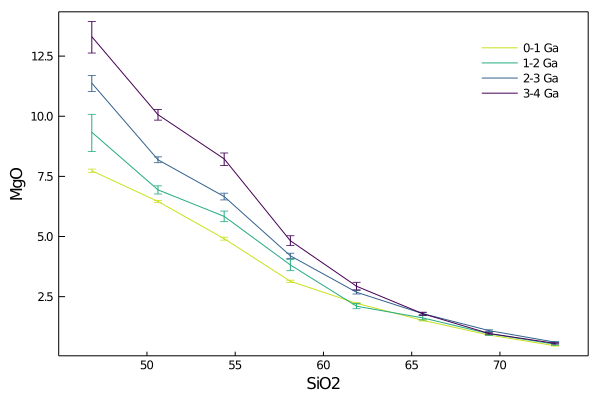

In [4]:
## --- Single element differentiation example
xelem = "SiO2"
xmin = 45
xmax = 75
nbins = 8
elem = "MgO"

h = plot(xlabel=xelem, ylabel="$(elem)",xlims=(xmin,xmax),framestyle=:box,grid=:off,fg_color_legend=:white) # Format plot

rt = [0,1,2,3,4]
colors = reverse(resize_colormap(viridis[1:end-20],length(rt)-1))
for i=1:length(rt)-1
    t = (ign["Age"].>rt[i]*1000) .& (ign["Age"].<rt[i+1]*1000)

    # Resample, returning binned means and uncertainties
    # (c = bincenters, m = mean, el = lower 95% CI, eu = upper 95% CI)
    (c,m,el,eu) = bin_bsr_means(ign[xelem][t],ign[elem][t],xmin,xmax,nbins, p=p[t],
                    x_sigma=ign[xelem*"_sigma"][t], y_sigma=ign[elem*"_sigma"][t])

    # Plot results
    plot!(h, c,m,yerror=(el,eu),color=colors[i],markerstrokecolor=:auto,label="$(rt[i])-$(rt[i+1]) Ga")
end
display(h)

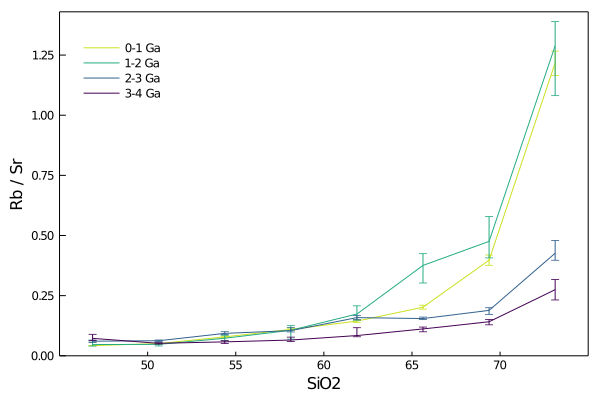

In [5]:
## --- Ratio differentiation example
xelem = "SiO2"
xmin = 45
xmax = 75
nbins = 8
num = "Rb" # Numerator
denom = "Sr" # Denominator

# # Exclude outliers
# t = t .& (ign[num] .> pctile(ign[num],0.5)) .& (ign[num] .< pctile(ign[num],99.5))
# t = t .& (ign[denom] .> pctile(ign[denom],0.5)) .& (ign[denom] .< pctile(ign[denom],99.5))

h = plot(xlabel=xelem, ylabel="$(num) / $(denom)",xlims=(xmin,xmax),framestyle=:box,grid=:off,legend=:topleft,fg_color_legend=:white) # Format plot

rt = [0,1,2,3,4]
colors = reverse(resize_colormap(viridis[1:end-20],length(rt)-1))
for i=1:length(rt)-1
    t = (ign["Age"].>rt[i]*1000) .& (ign["Age"].<rt[i+1]*1000)

    # Resample, returning binned means and uncertainties
    # (c = bincenters, m = mean, el = lower 95% CI, eu = upper 95% CI)
    (c,m,el,eu) = bin_bsr_ratio_medians(ign[xelem][t],ign[num][t],ign[denom][t],xmin,xmax,nbins, p=p[t],
                    x_sigma=ign[xelem*"_sigma"][t], num_sigma=ign[num*"_sigma"][t], denom_sigma=ign[denom*"_sigma"][t])

    # Plot results
    plot!(h, c,m,yerror=(el,eu),color=colors[i],markerstrokecolor=:auto,label="$(rt[i])-$(rt[i+1]) Ga")
end
display(h)

### Define functions to slice dataset into SiO2 bins and recombine to produce constant-silica model

In [6]:
## --- High-level functions for calculating combined averages over a set or silica ranges
function constprop(binbsrfunction::Function, dataset::Dict, elem, xmin, xmax, nbins, p; xelem="Age", norm_by="SiO2", norm_bins=[43,55,65,78], nresamplings=1000)
    c = zeros(nbins)
    m = zeros(nbins)
    el = zeros(nbins)
    eu = zeros(nbins)
    for i=1:length(norm_bins)-1
        # Find the samples we're looking for
        t = (dataset[norm_by].>norm_bins[i]) .& (dataset[norm_by].<norm_bins[i+1]) .& (dataset[elem].>0)

        # See what proportion of the modern crust falls in this norm_bin
        prop = sum((dataset[norm_by].>norm_bins[i]) .& (dataset[norm_by].<norm_bins[i+1]) .& (p .> 0)) / sum((dataset[norm_by].>norm_bins[1]) .& (dataset[norm_by].<norm_bins[end]) .& (p .> 0))

        # Resample, returning binned means and uncertainties
        # (c = bincenters, m = mean, el = lower 95% CI, eu = upper 95% CI)
        (c[:],m1,el1,eu1) = binbsrfunction(dataset[xelem][t], dataset[elem][t], xmin, xmax, nbins, x_sigma=dataset["$(xelem)_sigma"][t], nresamplings=nresamplings, p=p[t])

        m .+= prop.*m1
        el .+= prop.*el1
        eu .+= prop.*eu1
    end
    el ./= sqrt(length(norm_bins)-1) # Standard error
    eu ./= sqrt(length(norm_bins)-1) # Standard error

    return c, m, el, eu
end

function constprop(binbsrfunction::Function, dataset::Dict, num, denom, xmin, xmax, nbins, p; xelem="Age", norm_by="SiO2", norm_bins=[43,55,65,78], nresamplings=1000)
    c = zeros(nbins)
    m = zeros(nbins)
    el = zeros(nbins)
    eu = zeros(nbins)
    for i=1:length(norm_bins)-1
        # Find the samples we're looking for
        t = (dataset[norm_by].>norm_bins[i]) .& (dataset[norm_by].<norm_bins[i+1]) .& (dataset[num].>0) .& (dataset[denom].>0)

        # See what proportion of the modern crust falls in this norm_bin
        prop = sum((dataset[norm_by].>norm_bins[i]) .& (dataset[norm_by].<norm_bins[i+1]) .& (p .> 0)) / sum((dataset[norm_by].>norm_bins[1]) .& (dataset[norm_by].<norm_bins[end]) .& (p .> 0))

        # Resample, returning binned means and uncertainties
        # (c = bincenters, m = mean, el = lower 95% CI, eu = upper 95% CI)
        (c[:],m1,el1,eu1) = binbsrfunction(dataset[xelem][t],dataset[num][t],dataset[denom][t],xmin,xmax,nbins,x_sigma=dataset["$(xelem)_sigma"][t],num_sigma=dataset["$(num)_sigma"][t],denom_sigma=dataset["$(denom)_sigma"][t],nresamplings=nresamplings,p=p[t])

        m .+= prop.*m1
        el .+= prop.*el1
        eu .+= prop.*eu1
    end
    el ./= sqrt(length(norm_bins)-1) # Standard error
    eu ./= sqrt(length(norm_bins)-1) # Standard error

    return c, m, el, eu
end

constprop (generic function with 2 methods)

### Plot results for constant-silica reference model

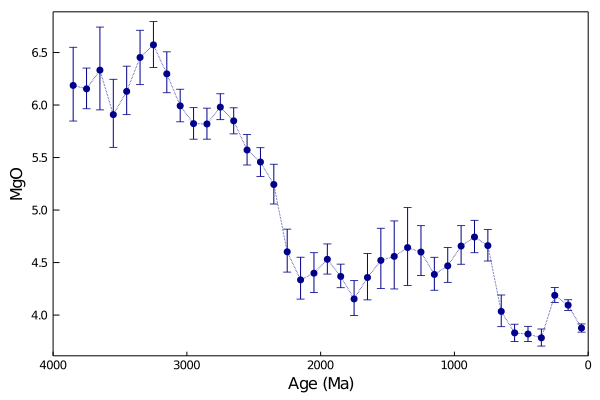

In [7]:
## --- Single element constant-silica reference model
tmin = 0
tmax = 3900
nbins = 39

plotmin = 0
plotmax = 4000

elem = "MgO"

(c, m, el, eu) = constprop(bin_bsr_means, ign, elem, tmin, tmax, nbins, p)

# Plot results
h = plot(c,m,yerror=(el,eu),seriestype=:scatter,color=:darkblue,markerstrokecolor=:auto,label="")
plot!(h, c,m,style=:dot,color=:darkblue,markerstrokecolor=:auto,label="")
plot!(h, xlabel="Age (Ma)", ylabel="$(elem)",xlims=(plotmin,plotmax),framestyle=:box,grid=:off,xflip=true) # Format plot

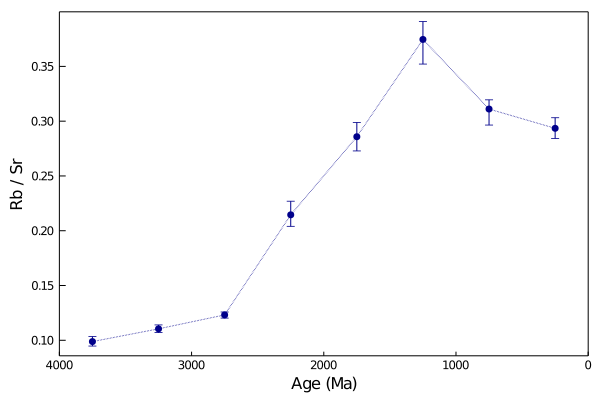

In [8]:
## --- Ratio constant-silica reference model
tmin = 0
tmax = 4000
nbins = 8

plotmin = 0
plotmax = 4000

num = "Rb"
denom = "Sr"

(c, m, el, eu) = constprop(bin_bsr_ratio_medians, ign, num, denom, tmin, tmax, nbins, p)

# Plot results
h = plot(c,m,yerror=(el,eu),seriestype=:scatter,color=:darkblue,markerstrokecolor=:auto,label="")
plot!(h, c,m,style=:dot,color=:darkblue,markerstrokecolor=:auto,label="")
plot!(h, xlabel="Age (Ma)", ylabel="$(num) / $(denom)",xlims=(plotmin,plotmax),framestyle=:box,grid=:off,xflip=true) # Format plot